<a href="https://colab.research.google.com/github/coldjoke123/python1/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 主題：運用神經網路及監督式學習法對Gisette資料進行識別

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


### 引入時間計算的封包

In [2]:
pip install pytictoc

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from keras.layers import concatenate, add
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.layers import Input
from pytictoc import TicToc

Using TensorFlow backend.


## 用資料上傳的方式讀入Gisette資料
### Gisette 資料內包含了
1. Gisette train data
2. Gisette train label
3. Gisette validation data      (以此作為 test data)
4. Gisette validation label       (以此作為 test label)

In [4]:
from google.colab import files
import io
uploaded = files.upload()

Saving gisette_train.data to gisette_train.data


In [0]:
dfGx0 = pd.read_csv(io.BytesIO(uploaded['gisette_train.data']),sep=' ', header=None)

In [6]:
uploaded = files.upload()

Saving gisette_train.labels to gisette_train.labels


In [0]:
dfGy0 = pd.read_csv(io.BytesIO(uploaded['gisette_train.labels']),sep=' ', header=None)

In [8]:
uploaded = files.upload()

Saving gisette_valid.data to gisette_valid.data


In [0]:
dfGxval0 = pd.read_csv(io.BytesIO(uploaded['gisette_valid.data']),sep=' ', header=None)

In [10]:
uploaded = files.upload()

Saving gisette_valid.labels to gisette_valid.labels


In [0]:
dfGyval0 = pd.read_csv(io.BytesIO(uploaded['gisette_valid.labels']),sep=' ', header=None)

## 整理所讀進之資料
### gisette分成 6000筆訓練資料及1000筆測試資料，每筆資料都經由預先處理成 $50\times100$ 的大小

In [12]:
dfGx0.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,550,0,495,0,0,0,0,976,0,0,0,0,983,0,995,0,983,0,0,983,0,0,0,0,0,983,0,0,0,0,0,0,0,0,0,0,0,0,991,983,...,0,0,513,0,533,811,0,0,0,983,0,0,0,0,0,983,991,0,0,0,983,0,0,0,0,0,0,0,0,0,0,0,991,991,0,0,0,0,983,NaN
1,0,0,0,0,0,0,0,976,0,0,0,0,0,0,584,0,0,0,0,0,0,0,0,0,0,983,0,0,0,0,0,0,0,0,0,898,0,0,0,0,...,0,0,932,0,0,764,828,0,0,0,983,0,0,0,0,0,991,0,0,0,0,0,0,0,0,0,0,0,0,0,475,0,991,0,0,991,0,0,0,NaN
2,0,0,0,0,0,0,0,0,0,0,0,0,983,0,995,983,976,0,0,0,0,0,0,0,0,983,0,742,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,991,0,0,991,0,0,0,0,0,0,0,0,0,0,584,0,0,0,0,0,940,0,0,0,0,0,616,0,0,0,0,0,0,0,0,0,0,NaN
3,0,0,742,0,0,0,0,684,0,956,0,0,983,0,991,816,983,0,0,0,0,0,0,0,0,685,0,767,0,0,0,0,0,0,991,0,0,0,0,0,...,0,0,748,0,0,729,0,991,0,808,0,0,0,0,0,0,991,0,874,0,859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,674,0,0,838,NaN
4,0,0,0,0,0,0,0,608,0,979,0,0,0,0,972,0,0,0,0,0,0,0,0,480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,991,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,675,780,0,0,0,0,983,0,0,0,0,0,991,0,0,828,0,0,0,0,0,0,NaN


In [13]:
dfGx0.values.shape

(6000, 5001)

In [14]:
dfGxval0.values.shape

(1000, 5001)

### 將訓練資料正規化，並且將labels類別化

由於原先的label內是為 -1與1的取值，先將 -1的值改成0再行類別化。

In [0]:
# train data
dfGx = dfGx0.drop(columns=5000)
dfGx = dfGx.values
dfGx = dfGx.reshape((6000,50*100))
dfGx -= dfGx.min()
dfGx = dfGx/dfGx.max()
# test data
dfGxval = dfGxval0.drop(columns=5000)
dfGxval = dfGxval.values
dfGxval = dfGxval.reshape((1000,50*100))
dfGxval -= dfGxval.min()
dfGxval = dfGxval/dfGxval.max()

In [0]:
# train label
dfGy = dfGy0.values
dfGy = dfGy.reshape(1,6000)[0]
for i in range(len(dfGy)):
    if dfGy[i] == -1:
        dfGy[i] = 0
dfGy = to_categorical(dfGy, 2)
# test label
dfGyval = dfGyval0.values
dfGyval = dfGyval.reshape(1,1000)[0]
for i in range(len(dfGyval)):
    if dfGyval[i] == -1:
        dfGyval[i] = 0
dfGyval = to_categorical(dfGyval, 2)

## 建構第一個簡單NN模型 (以下稱其為NN1)

In [17]:
x = Input(shape=(5000,))
f_1 = Dense(100,activation='sigmoid')
f_2 = Dense(50,activation='relu')
f_3 = Dense(2,activation='softmax')
y = f_3(f_2(f_1(x)))
NNmod = Model(x, y)
NNmod.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               500100    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 505,252
Trainable params: 505,252
Non-trainable params: 0
_________________________________________________________________


###下圖為此模型的圖像

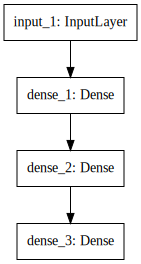

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(NNmod).create(prog='dot', format='svg'))

In [19]:
NNmod.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.05), metrics=['accuracy'])
NN = NNmod.fit(dfGx, dfGy, batch_size=10, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6000/6000 [==============================] - 6s 1ms/step - loss: 0.1988 - acc: 0.9228
Epoch 2/5
6000/6000 [==============================] - 4s 717us/step - loss: 0.0717 - acc: 0.9765
Epoch 3/5
6000/6000 [==============================] - 4s 651us/step - loss: 0.0376 - acc: 0.9883
Epoch 4/5
6000/6000 [==============================] - 4s 626us/step - loss: 0.0183 - acc: 0.9950
Epoch 5/5
6000/6000 [==============================] - 4s 615us/step - loss: 0.0078 - acc: 0.9983


In [20]:
t = TicToc()
t.tic()
score = NNmod.evaluate(dfGxval,dfGyval)
t.toc()
print('loss:', score[0])
print('正確率:', score[1])

1000/1000 [==============================] - 0s 161us/step
Elapsed time is 0.164568 seconds.
loss: 0.07940706682205201
正確率: 0.973


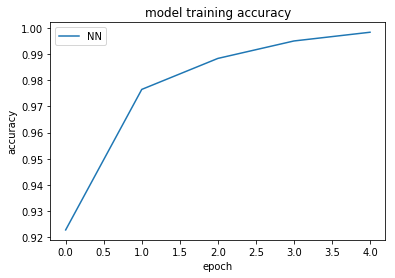

In [21]:
plt.plot(NN.history["acc"])
         
plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['NN'], loc = 'best')
plt.show()

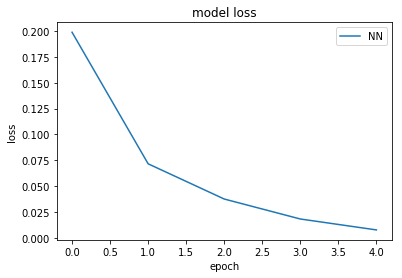

In [22]:
plt.plot(NN.history['loss'])
         
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['NN'], loc = 'best')
plt.show()

## NN1模型對於Gisette 資料的準確率有$97.3\%$，估計是因為overfitting

## SVM
### 我們使用scikit-learn 套件內的 svm 來建立模型

In [23]:
from sklearn import svm, preprocessing, metrics

# train label
dfGysvm = dfGy0.values
dfGysvm = dfGysvm.reshape(1,6000)[0]
# test label
dfGyvalsvm = dfGyval0.values
dfGyvalsvm = dfGyvalsvm.reshape(1,1000)[0]

svc = svm.SVC()
svc_fit = svc.fit(dfGx, dfGysvm)

# 預測
t = TicToc()
t.tic()
pred_dfGysvm = svc.predict(dfGxval)
t.toc()

# 績效
accuracy = metrics.accuracy_score(dfGyvalsvm, pred_dfGysvm)
print('the accuracy of svm is:' , accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Elapsed time is 18.984024 seconds.
the accuracy of svm is: 0.968


## SVM 對Gisette資料的識別準確率也有達到$96.8\%$，僅僅低於第一個NN模型不到$1\%$，但預測的時間遠遠多於NN模型。

## Random Forest

### 我們使用scikit-learn套件內的ensemble來建立模型

首先，我們先給定20顆樹

In [28]:
from sklearn import ensemble, preprocessing, metrics

forest1 = ensemble.RandomForestClassifier(n_estimators = 20)
forest_fit = forest1.fit(dfGx, dfGy)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest1.predict(dfGxval)
t.toc()

# 績效
accuracy = metrics.accuracy_score(dfGyval, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.023557 seconds.
the accuracy of random forest is: 0.954


將樹的個數增加到50顆

In [29]:
forest2 = ensemble.RandomForestClassifier(n_estimators = 50)
forest_fit = forest2.fit(dfGx, dfGy)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest2.predict(dfGxval)
t.toc()

# 績效
accuracy = metrics.accuracy_score(dfGyval, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.036327 seconds.
the accuracy of random forest is: 0.97


將樹的個數增加到80顆

In [30]:
forest3 = ensemble.RandomForestClassifier(n_estimators = 80)
forest_fit = forest3.fit(dfGx, dfGy)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest3.predict(dfGxval)
t.toc()

# 績效
accuracy = metrics.accuracy_score(dfGyval, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.050481 seconds.
the accuracy of random forest is: 0.963


## Random forest 對Gisette資料的識別準確率大約都落在$95\sim97\%$之間，算是蠻高的，但增加太多樹不一定會提升準確率。此外，Random forest 的預測時間比NN模型來的短。

## 修改一些NN模型的參數或是多加幾層可能可以提升準確率；Random forest 比起另外兩個模型可能準確性差了一點，但預測的速度相對較快；SVM由於其演算法的因素，準確率較NN模型稍低，但可能較能廣義地運用在其他的測試資料上。

## 此外，由於我們並未能瞭解Gisette資料所進行了怎麼樣的預處理而進行資料適當的還原，我們決定從原本的mnist手寫資料中自行提取出4與9的訓練及測試資料再做一次。

In [39]:
from keras.datasets import mnist
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
x_train = x_train0.reshape((60000,28*28))
x_test = x_test0.reshape((10000,28*28))
x_train -= x_train.min()
x_train = x_train/x_train.max()
x_test -= x_test.min()
x_test = x_test/x_test.max()

###提取4與9的資料

對label的資料類別化

其中訓練資料有11791筆，測試資料有1991筆

In [0]:
x4 = x_train[y_train0 == 4]
x9 = x_train[y_train0 == 9]
Gx_train = np.concatenate((x4,x9))
y4 = y_train0[y_train0 == 4]
y9 = y_train0[y_train0 == 9]
Gy_train = np.concatenate((y4,y9))

In [0]:
for i in range(len(Gy_train)):
    if Gy_train[i] == 4:
        Gy_train[i] = 0
    else:
        Gy_train[i] = 1        
Gy_train = to_categorical(Gy_train, 2)

In [0]:
x4t = x_test[y_test0 == 4]
x9t = x_test[y_test0 == 9]
Gx_test = np.concatenate((x4t,x9t))
y4t = y_test0[y_test0 == 4]
y9t = y_test0[y_test0 == 9]
Gy_test = np.concatenate((y4t,y9t))

In [0]:
for i in range(len(Gy_test)):
    if Gy_test[i] == 4:
        Gy_test[i] = 0
    else:
        Gy_test[i] = 1
Gy_test = to_categorical(Gy_test, 2)

In [51]:
Gx_train.shape

(11791, 784)

In [52]:
Gx_test.shape

(1991, 784)

##建構第二個簡單NN模型 (以下稱其為NN2)

In [47]:
x = Input(shape=(784,))
f_1 = Dense(100,activation='sigmoid')
f_2 = Dense(50,activation='relu')
f_3 = Dense(2,activation='softmax')
y = f_3(f_2(f_1(x)))
NNmod2 = Model(x, y)
NNmod2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total params: 83,652
Trainable params: 83,652
Non-trainable params: 0
_________________________________________________________________


In [49]:
NNmod2.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.05), metrics=['accuracy'])
NN2 = NNmod2.fit(Gx_train, Gy_train, batch_size=10, epochs=5)

Epoch 1/5
11791/11791 [==============================] - 2s 207us/step - loss: 0.1920 - acc: 0.9204
Epoch 2/5
11791/11791 [==============================] - 2s 181us/step - loss: 0.1076 - acc: 0.9623
Epoch 3/5
11791/11791 [==============================] - 2s 182us/step - loss: 0.0982 - acc: 0.9640
Epoch 4/5
11791/11791 [==============================] - 2s 179us/step - loss: 0.0876 - acc: 0.9696
Epoch 5/5
11791/11791 [==============================] - 2s 178us/step - loss: 0.0765 - acc: 0.9734


In [50]:
t = TicToc()
t.tic()
score = NNmod2.evaluate(Gx_test,Gy_test)
t.toc()
print('loss:', score[0])
print('正確率:', score[1])

1991/1991 [==============================] - 0s 80us/step
Elapsed time is 0.162232 seconds.
loss: 0.08125813390230756
正確率: 0.9718734304369664


## NN2 對直接取出4與9的mnist資料的辨識準確率與NN1相去不遠，都有在$97.2\%$左右

##SVM

In [54]:
# train label
Gysvm_train = np.concatenate((y4,y9))
# test label
Gysvm_test = np.concatenate((y4t,y9t))

svm1 = svm.SVC()
svc_fit = svm1.fit(Gx_train, Gysvm_train)

# 預測
t = TicToc()
t.tic()
pred_Gysvm1 = svm1.predict(Gx_test)
t.toc()

# 績效
accuracy = metrics.accuracy_score(Gysvm_test, pred_Gysvm1)
print('the accuracy of svm is:' , accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Elapsed time is 6.601077 seconds.
the accuracy of svm is: 0.9683576092415871


## SVM 對於直接取出4與9的mnist資料的辨識準確率同樣是為$96.8\%$，預測時間雖比起NN2來得久，但比起Gisette資料時快很多。

##Random forest

首先，我們先給定20顆樹

In [56]:
forest1 = ensemble.RandomForestClassifier(n_estimators = 20)
forest1_fit = forest1.fit(Gx_train, Gy_train)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest1.predict(Gx_test)
t.toc()

# 績效
accuracy = metrics.accuracy_score(Gy_test, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.017217 seconds.
the accuracy of random forest is: 0.9799095931692616


將樹的個數增加到50顆

In [57]:
forest1 = ensemble.RandomForestClassifier(n_estimators = 50)
forest1_fit = forest1.fit(Gx_train, Gy_train)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest1.predict(Gx_test)
t.toc()

# 績效
accuracy = metrics.accuracy_score(Gy_test, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.036883 seconds.
the accuracy of random forest is: 0.9809141135107986


將樹的個數增加到80顆

In [58]:
forest1 = ensemble.RandomForestClassifier(n_estimators = 80)
forest1_fit = forest1.fit(Gx_train, Gy_train)

# 預測
t = TicToc()
t.tic()
pred_Gyf = forest1.predict(Gx_test)
t.toc()

# 績效
accuracy = metrics.accuracy_score(Gy_test, pred_Gyf)
print('the accuracy of random forest is:' , accuracy)

Elapsed time is 0.053540 seconds.
the accuracy of random forest is: 0.9814163736815671


## Random forest 此次的辨識率突破了$98\%$! 在增加樹的方面有提升準確率，但並未提高很多。此外，我們也不排除有overfitting 的問題。

#小結：
## 此次我們對於兩種資料使用了神經網路與監督式學習(SVM 與 Random forest)進行資料的分類，可能由於Gisette資料的預先處理並未對原本mnist資料進行太多的改變，同一種方法對兩種不同資料的辨識率相去不遠，並且都有很高的準確性。而所使用的三種方法中，SVM的預測時間最久而Random forest最短(對兩種資料都是)。在Gisette資料中，以神經網路的預測準確率最高，而在mnist資料中，Random forest 可以達到$98\%$以上。